In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

df = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro.csv')

df

,x,y,z
0,42159.783600,0.000000,0.000000
1,39159.545914,15563.916303,266.913399
2,30572.229294,28909.053086,496.928223
3,17596.068412,38144.740319,671.356184
4,2068.446366,41949.706443,775.646554
...,...,...,...
995,38132.961517,21370.880108,-7532.333000
996,31399.515894,31233.289707,1828.575655
997,20906.077447,37238.565267,10967.804062
998,7871.245318,38575.122415,18731.818721


Now we want to predict X values (can change for Y, Z):

In [2]:
#Create a new dataframe with only the x column
data = df.filter(['x']) # CHANGE FOR Y,Z

#Convert the dataframe to a numpy array
dataset = data.values

#Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * 0.8 ))

training_data_len

800

In [3]:
#Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

In [4]:
# Set roll-back window
window = 60 # default was set to 60 before

In [5]:
#Create the training data set
#Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]

#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(window, len(train_data)):
    x_train.append(train_data[i-window:i, 0])
    y_train.append(train_data[i, 0])

# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(740, 60, 1)

In [6]:
#Create the testing data set
#Create a new array containing scaled values
test_data = scaled_data[training_data_len - window: , :]

#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(window, len(test_data)):
    x_test.append(test_data[i-window:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(200, 60, 1)

## Model 1: Uni-Variate

In [7]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Build the LSTM model
# Note: replace LSTM with GRU or RNN if you want to try those
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1))) # input_shape = (60,1)
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history=model.fit(x_train, y_train, batch_size=16, epochs=10)

# Plot Training Loss
plt.plot(history.history['loss']) # add validation loss
plt.title('model loss')
plt.ylabel('period')
plt.xlabel('epoch')
plt.legend(['training'], loc='upper right')
plt.show()

Epoch 1/10
47/47 [==============================] - 3s 57ms/step - loss: 0.1128
Epoch 2/10
36/47 [=====================>........] - ETA: 0s - loss: 0.0036

KeyboardInterrupt: 

In [ ]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

In [ ]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('X-Coord', fontsize=18)
plt.plot(train['x'])
plt.plot(valid[['x', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

## Error plot:

In [ ]:
valid['Error']=abs(valid.Predictions-valid.x)/6738 # the normalization ct is taken as ISS semi-major axis
valid.Error.plot()
# add labels and units!!!

## Model 2: Multi-Variate

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

df = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro.csv')
df_v = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro_vv.csv')

df['x_vv']=df_v.vv_x
df['y_vv']=df_v.vv_y
df['z_vv']=df_v.vv_z

df

,x,y,z,x_vv,y_vv,z_vv
0,42159.783600,0.000000,0.000000,0.000000,3.074505,0.053666
1,39159.545914,15563.916303,266.913399,-1.142984,2.852848,0.048528
2,30572.229294,28909.053086,496.928223,-2.127756,2.228986,0.039518
3,17596.068412,38144.740319,671.356184,-2.813645,1.287415,0.027234
4,2068.446366,41949.706443,775.646554,-3.098444,0.161675,0.012698
...,...,...,...,...,...,...
995,38132.961517,21370.880108,-7532.333000,-0.876644,2.199413,1.750026
996,31399.515894,31233.289707,1828.575655,-1.692745,1.562118,1.820311
997,20906.077447,37238.565267,10967.804062,-2.312211,0.726117,1.664753
998,7871.245318,38575.122415,18731.818721,-2.661184,-0.221639,1.293445


In [9]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, look_back):
    dataX = []
    dataY = []
    for i in range(len(dataset) - look_back -1):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 2])
    return np.array(dataX), np.array(dataY)

In [10]:
# load the dataset
dataset = df.values

# normalize the dataset
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)

In [11]:
# split into train and test sets
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

# reshape into X=t and Y=t+1
look_back = 60
trainX, trainY = create_dataset(train, look_back)  
testX, testY = create_dataset(test, look_back)

# reshape input to be  [length of train/test data, window size (def=60), features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, 6))
testX = np.reshape(testX, (testX.shape[0],look_back, 6))

In [12]:
trainX.shape

(739, 60, 6)

In [34]:
print(trainX[0]) # (60 x 6 dimensions)

[[1.         0.51268296 0.51384449 0.50642219 0.97543823 0.5308229 ]
 [0.96495741 0.68978874 0.51906179 0.32405106 0.94073231 0.52945835]
 [0.86465808 0.84164646 0.52355785 0.16692372 0.84305165 0.52706564]
 [0.71309733 0.94674171 0.52696736 0.05748543 0.69562577 0.5238032 ]
 [0.53173566 0.99003939 0.5290059  0.01204375 0.51936392 0.51994289]
 [0.34651968 0.96549699 0.52951684 0.0373734  0.34043631 0.51587671]
 [0.18377842 0.8772233  0.5285067  0.1285896  0.1855856  0.51205093]
 [0.06588722 0.73863033 0.52614518 0.27025402 0.07653767 0.50885445]
 [0.00799281 0.56973581 0.52272405 0.44059861 0.0262484  0.50652769]
 [0.01656767 0.39367318 0.51859402 0.61644663 0.03846296 0.50514181]
 [0.08955821 0.23352883 0.51410738 0.7764203  0.10957296 0.50464551]
 [0.21731751 0.10997278 0.50958579 0.90194669 0.23062062 0.50494354]
 [0.38368148 0.03942669 0.50531849 0.977321   0.38803569 0.50597231]
 [0.56718212 0.03226843 0.50158463 0.99062129 0.56323966 0.5077463 ]
 [0.74295892 0.09091244 0.49868316

In [13]:
testX.shape

(139, 60, 6)

Epoch 1/10
47/47 [==============================] - 8s 179ms/step - loss: 0.0249
Epoch 2/10
47/47 [==============================] - 4s 78ms/step - loss: 0.0053
Epoch 3/10
47/47 [==============================] - 3s 64ms/step - loss: 0.0023
Epoch 4/10
47/47 [==============================] - 3s 72ms/step - loss: 3.1728e-04
Epoch 5/10
47/47 [==============================] - 4s 78ms/step - loss: 1.6537e-04
Epoch 6/10
47/47 [==============================] - 3s 66ms/step - loss: 1.1716e-04
Epoch 7/10
47/47 [==============================] - 3s 55ms/step - loss: 1.0198e-04
Epoch 8/10
47/47 [==============================] - 3s 54ms/step - loss: 1.2805e-04
Epoch 9/10
47/47 [==============================] - 3s 58ms/step - loss: 1.0448e-04
Epoch 10/10
47/47 [==============================] - 3s 62ms/step - loss: 9.5609e-05


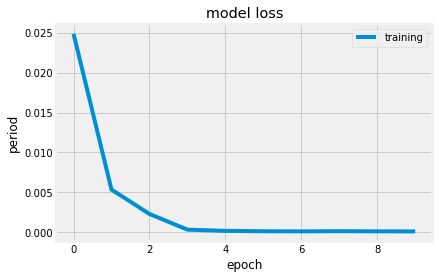

In [14]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
# Note: replace LSTM with GRU or RNN if you want to try those
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (look_back, 6)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history=model.fit(trainX, trainY, batch_size=16, epochs=10)

# Plot Training Loss
plt.plot(history.history['loss']) # add validation loss
plt.title('model loss')
plt.ylabel('period')
plt.xlabel('epoch')
plt.legend(['training'], loc='upper right')
plt.show()

In [15]:
# Get the models predicted price values 
predictions = model.predict(testX)
#predictions = scaler.inverse_transform(predictions)

# Get something which has as many features as dataset
predict_ext = np.zeros((len(predictions), 6))
# Put the predictions there
predict_ext[:,2] = predictions[:,0]
# Inverse transform it and select the 3rd column.
predictions = scaler.inverse_transform(predict_ext)[:,2]

testY_extended = np.zeros((len(testY),6))
testY_extended[:,2]=testY
testY=scaler.inverse_transform(testY_extended)[:,2]

In [16]:
# RMSE
rmse = np.sqrt(np.mean(((predictions - testY) ** 2)))
rmse

922.6374605257187

In [17]:
# Plot the data
train = df[:train_size]
test = df[train_size:]
test

,x,y,z,x_vv,y_vv,z_vv
800,-38640.279625,-2764.935183,17604.980941,-0.242379,-2.869481,-1.032661
801,-37222.004154,-17134.306183,11135.984105,0.783117,-2.603604,-1.431914
802,-30699.416577,-29154.049729,3087.546466,1.701144,-1.974296,-1.633559
803,-19981.800403,-37148.488205,-5420.909441,2.380643,-1.071344,-1.607049
804,-6568.003292,-40025.406603,-13203.492438,2.729043,-0.025797,-1.357603
...,...,...,...,...,...,...
995,38132.961517,21370.880108,-7532.333000,-0.876644,2.199413,1.750026
996,31399.515894,31233.289707,1828.575655,-1.692745,1.562118,1.820311
997,20906.077447,37238.565267,10967.804062,-2.312211,0.726117,1.664753
998,7871.245318,38575.122415,18731.818721,-2.661184,-0.221639,1.293445


In [18]:
dataa = {'testY': testY, 'predictions': predictions}
dff = pd.DataFrame.from_dict(dataa)

In [23]:
predictions

array([-11793.50028658,  -3221.14205141,   6006.85856377,  14640.47629883,
        21388.0777961 ,  25170.82256535,  25380.32978058,  22007.738091  ,
        15596.84047984,   7094.74031519,  -2298.89071669, -11269.61332466,
       -18568.8887966 , -23230.91794566, -24719.30984475, -22938.18500613,
       -18161.00594255, -10961.09591345,  -2176.47691874,   7112.44777012,
        15646.27315626,  22145.97333374,  25567.31465   ,  25353.48348589,
        21555.0743123 ,  14774.10095576,   6009.89264637,  -3494.73244543,
       -12400.81537202, -19468.01401831, -23773.31757601, -24841.5310585 ,
       -22638.49006676, -17492.77135742, -10025.33605016,  -1111.74262564,
         8146.4326271 ,  16491.65395   ,  22671.98262882,  25690.31849315,
        25046.68437172,  20848.52338051,  13749.74892987,   4795.95772254,
        -4732.70828103, -13481.85290394, -20232.12447013, -24114.94422302,
       -24722.35841167, -22083.03568615, -16580.05527525,  -8881.69883813,
           99.09113034,  

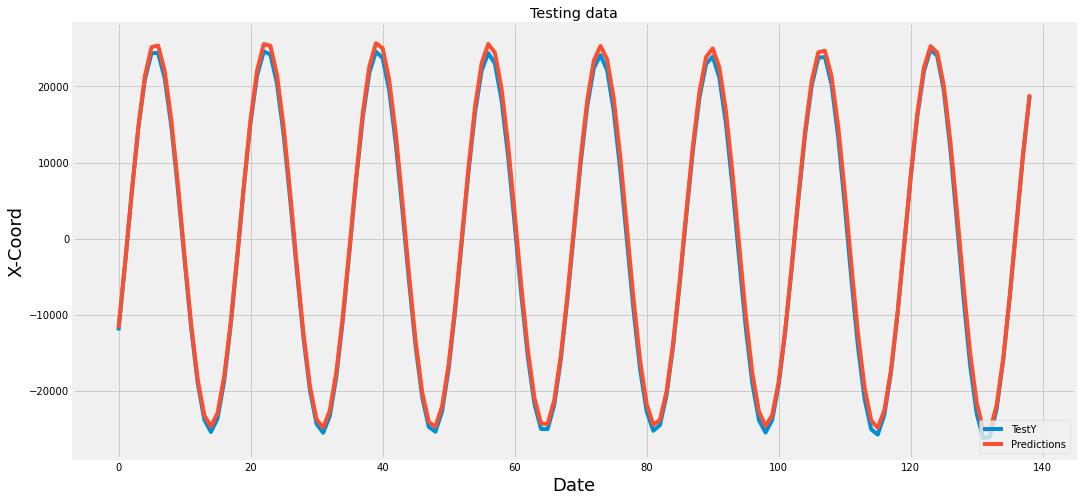

In [19]:
plt.figure(figsize=(16,8))
plt.title('Testing data')
plt.xlabel('Date', fontsize=18)
plt.ylabel('X-Coord', fontsize=18)
plt.plot(dff.testY)
plt.plot(dff.predictions)
plt.legend(['TestY', 'Predictions'], loc='lower right')
plt.show()

In [20]:
predictions

array([-11793.50028658,  -3221.14205141,   6006.85856377,  14640.47629883,
        21388.0777961 ,  25170.82256535,  25380.32978058,  22007.738091  ,
        15596.84047984,   7094.74031519,  -2298.89071669, -11269.61332466,
       -18568.8887966 , -23230.91794566, -24719.30984475, -22938.18500613,
       -18161.00594255, -10961.09591345,  -2176.47691874,   7112.44777012,
        15646.27315626,  22145.97333374,  25567.31465   ,  25353.48348589,
        21555.0743123 ,  14774.10095576,   6009.89264637,  -3494.73244543,
       -12400.81537202, -19468.01401831, -23773.31757601, -24841.5310585 ,
       -22638.49006676, -17492.77135742, -10025.33605016,  -1111.74262564,
         8146.4326271 ,  16491.65395   ,  22671.98262882,  25690.31849315,
        25046.68437172,  20848.52338051,  13749.74892987,   4795.95772254,
        -4732.70828103, -13481.85290394, -20232.12447013, -24114.94422302,
       -24722.35841167, -22083.03568615, -16580.05527525,  -8881.69883813,
           99.09113034,  